In [26]:
import pandas_datareader.data as web
from datetime import datetime, date
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import numpy as np
%matplotlib inline 


In [73]:
def get_risk_free_rate():
    """
    Obtiene el tipo de interés libre de riesgo (T-Bill 3M, ticker ^IRX) desde Yahoo Finance.
    Devuelve el valor diario equivalente (no anual).
    """
    t_bill = yf.Ticker("^IRX")
    data = t_bill.history(period="5d")  # últimos 5 días para evitar problemas de días festivos
    last_yield = data["Close"].iloc[-1] / 100.0  # convertir % a decimal
    
    # Pasar de anual a diario (252 días de mercado al año)
    risk_free_daily = (1 + last_yield) ** (1/252) - 1
    return risk_free_daily


def compute_sharpe_ratio(data, risk_free_rate = 0):
    mean_return = data["Daily Return"].mean()
    std = data["Daily Return"].std()
    sharpe_ratio = (mean_return-risk_free_rate) / std
    return sharpe_ratio

def compute_alpha_beta(stock_data, benchmark_data):
    """
    Calcula Alpha y Beta de un activo respecto a un benchmark.
    stock_data y benchmark_data deben ser Series con retornos diarios (%).
    """
    # Alinear índices de fechas
    data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

    stock_returns = data.iloc[:, 0].pct_change(1).dropna()
    benchmark_returns = data.iloc[:, 1].pct_change(1).dropna()

    # Regresión lineal: stock = alpha + beta * benchmark
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(stock_returns, X).fit()
    alpha, beta = model.params

    return alpha, beta

def call_yf_api_historic(start_period, end_period, ticker):
    data = yf.download(ticker, start_period , end_period, auto_adjust=True)
    data.columns = data.columns.droplevel('Ticker')
    data["Daily Return"] = data["Close"].pct_change(1)
    data = data.dropna()
    data["Cumulative Return"] = (1 + data["Daily Return"]).cumprod() - 1
    return data

def extraction_historic(start_period, end_period, tickers):
    data_his = {}
    
    for ticker in tqdm(tickers, desc="Procesando tickers"):
        name_ticker = tickers[ticker]
        data_his[name_ticker] = call_yf_api_historic(start_period, end_period, ticker)
    return data_his

def interpretar_recomendacion(val):
    if val is None:
        return None
    elif val < 1.5:
        return "Compra fuerte (Strong Buy)"
    elif val < 2.5:
        return "Compra (Buy)"
    elif val < 3.5:
        return "Mantener (Hold)"
    elif val < 4.5:
        return "Vender (Underperform / Sell)"
    else:
        return "Vender fuerte (Strong Sell)"

def interpretar_sharpe(sharpe):
    if sharpe is None or pd.isna(sharpe):
        return None
    elif sharpe < 0:
        return "Mala inversión (rinde peor que activo libre de riesgo)"
    elif sharpe < 1:
        return "Rentabilidad baja para el riesgo asumido"
    elif sharpe < 2:
        return "Aceptable"
    elif sharpe < 3:
        return "Buena"
    else:
        return "Excelente"

def analysis_stock_hist(df_raw, tickers, bechmark_df):
    # Valores posibles:
    
    # 👉 En teoría: puede ser cualquier número real (positivo, negativo o cercano a cero).
    # 🔴 < 0 → la inversión rinde peor que un activo libre de riesgo (mala señal).
    # 🟠 0 – 1 → rentabilidad baja respecto al riesgo, poco atractivo.
    # 🟡 1 – 2 → inversión aceptable/buena.
    # 🟢 2 – 3 → inversión muy buena.
    # 🟢 > 3 → inversión excelente (pocas veces se da en mercados reales).
    rows = []

    for name, df in tqdm(df_raw.items(), desc="Procesando tickers"):
        ticker = [k for k, v in tickers.items() if v == name][0]
        ret_1m = df["Cumulative Return"].iloc[-1]  # último valor
        ret_2m = df["Cumulative Return"].iloc[-31]  # último valor
        ret_3m = df["Cumulative Return"].iloc[-61]  # último valor
        precio_actual = df["Close"].iloc[-1]  # último valor
        ret_3m = df["Cumulative Return"].iloc[-61]  # último valor
        volatilidad = df["Daily Return"].std()
    
        company_data = yf.Ticker(ticker).info
        sector = company_data.get("sector")
        industry = company_data.get("industry")
        market_cap = company_data.get("marketCap")
        recommendation = company_data.get("recommendationMean")
        
        target_price = company_data.get("targetMeanPrice")
        recommendation_interpratation = interpretar_recomendacion(recommendation)
        
        sharpe_ratio = compute_sharpe_ratio(df)
        sharpe_interpretation = interpretar_sharpe(sharpe_ratio)

        alpha, beta = compute_alpha_beta(df["Close"], bechmark_df["Close"])

        if target_price is not None:
            rentabilidad_prevista = round((target_price-precio_actual) / precio_actual * 100.0, 1)
        else:
            rentabilidad_prevista = None 
        rows.append({
            "Empresa": name,
            "Ticker": ticker,
            "Sector": sector,
            "Industria": industry,
            "Capitalización mercado": market_cap,
            "Retorno 1 mes": ret_1m,
            "Retorno 2 meses": ret_2m,
            "Retorno 3 meses": ret_3m,
            "Precio actual": precio_actual,
            "Precio objetivo analistas": target_price,
            "Rentabilidad prevista": rentabilidad_prevista,
            "Valoración analistas": recommendation,
            "Interpretacion recomendacion": recommendation_interpratation,
            "sharpe_ratio": sharpe_ratio,
            "Interpretacion Sharpe": sharpe_interpretation,
            "volatilidad": volatilidad,
            "alpha": alpha, 
            "beta": beta
        })
    df_ranking = pd.DataFrame(rows)
    return df_ranking.sort_values('Rentabilidad prevista', ascending=False)



In [74]:
get_risk_free_rate()

0.00015290123363231878

In [68]:
start_period = datetime(2025,5,1)
end_period =  datetime(2025,9,11)
ibex35_tickers = {
    "ANA.MC":  "Acciona",
    "ANE.MC":  "Acciona Energía",
    "ACX.MC":  "Acerinox",
    "ACS.MC":  "ACS",
    "AENA.MC": "Aena",
    "AMS.MC":  "Amadeus",
    "BBVA.MC": "BBVA",
    "BKT.MC":  "Bankinter",
    "CABK.MC": "CaixaBank",
    "CLNX.MC": "Cellnex Telecom",
    "COL.MC":  "Inmobiliaria Colonial",
    "ELE.MC":  "Endesa",
    "ENG.MC":  "Enagás",
    "FDR.MC":  "Fluidra",
    "FER.MC":  "Ferrovial",
    "GRF.MC":  "Grifols",
    "IAG.MC":  "IAG (International Airlines Group)",
    "IBE.MC":  "Iberdrola",
    "IDR.MC":  "Indra",
    "ITX.MC":  "Inditex",
    "LOG.MC":  "Logista",
    "MAP.MC":  "Mapfre",
    "MEL.MC":  "Meliá Hotels International",
    "MRL.MC":  "Merlin Properties",
    "MTS.MC":  "ArcelorMittal",
    "NTGY.MC": "Naturgy",
    "PUIG.MC": "Puig",
    "RED.MC":  "Redeia",
    "REP.MC":  "Repsol",
    "ROVI.MC": "Rovi",
    "SAB.MC":  "Banco Sabadell",
    "SAN.MC":  "Banco Santander",
    "SCYR.MC": "Sacyr",
    "SLR.MC":  "Solaria",
    "TEF.MC":  "Telefónica",
    "UNI.MC":  "Unicaja Banco"
}
bechmark_ibex35 = call_yf_api_historic(start_period, end_period, '^IBEX')
ibex35_df = extraction_historic(start_period, end_period, ibex35_tickers)
ibex35_analysed_df = analysis_stock_hist(ibex35_df, ibex35_tickers, bechmark_ibex35)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/36 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/36 [00:00<00:07,  4.68it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/36 [00:00<00:06,  5.00it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 3/36 [00:00<00:07,  4.56it/s]
[*********************100%***********************] 

In [78]:
ibex35_analysed_df.head()

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,Interpretacion Sharpe,volatilidad,alpha,beta
9,Cellnex Telecom,CLNX.MC,Real Estate,Real Estate Services,20617220096,-0.145909,-0.109872,-0.068161,30.100000,41.55217,38.0,NaN,None,-0.126422,Mala inversión (rinde peor que activo libre de...,0.012765,-0.001998,0.217096
29,Rovi,ROVI.MC,Healthcare,Drug Manufacturers - Specialty & Generic,3076642560,0.160696,0.078627,0.057637,59.400002,79.41250,33.7,1.75000,Compra (Buy),0.120545,Rentabilidad baja para el riesgo asumido,0.014115,0.001076,0.440991
15,Grifols,GRF.MC,Healthcare,Drug Manufacturers - General,7380758016,0.442594,0.584779,0.216581,12.160000,15.85833,30.4,1.91667,Compra (Buy),0.199079,Rentabilidad baja para el riesgo asumido,0.020896,0.002970,0.918597
10,Inmobiliaria Colonial,COL.MC,Real Estate,REIT - Office,3467190528,0.028212,0.070180,0.081128,5.635000,7.03059,24.8,2.11765,Compra (Buy),0.032327,Rentabilidad baja para el riesgo asumido,0.011167,-0.000599,0.645246
18,Indra,IDR.MC,Technology,Information Technology Services,5788154368,0.127909,0.255909,0.240601,32.779999,40.74615,24.3,1.85714,Compra (Buy),0.070369,Rentabilidad baja para el riesgo asumido,0.021717,0.000412,0.757015


In [45]:
tickers_sp500 = {
    "AAPL": "Apple Inc.",
    "MSFT": "Microsoft Corporation",
    "NVDA": "NVIDIA Corporation",
    "GOOGL": "Alphabet Inc. (Clase A)",
    "AMZN": "Amazon.com, Inc.",
    "META": "Meta Platforms, Inc.",
    "TSLA": "Tesla, Inc.",
    "BRK-B": "Berkshire Hathaway Inc.",
    "JPM": "JPMorgan Chase & Co.",
    "V": "Visa Inc.",
    "LLY": "Eli Lilly and Co.",
    "JNJ": "Johnson & Johnson",
    "PG": "Procter & Gamble Co.",
    "UNH": "UnitedHealth Group Incorporated",
    "HD": "Home Depot, Inc.",
    "ABBV": "AbbVie Inc.",
    "BAC": "Bank of America Corporation",
    "KO": "Coca-Cola Company",
    "PEP": "PepsiCo, Inc.",
    "CRM": "Salesforce, Inc.",
    "ORCL": "Oracle Corporation",
    "CSCO": "Cisco Systems, Inc.",
    "TMO": "Thermo Fisher Scientific Inc.",
    "QCOM": "Qualcomm Incorporated",
    "ADBE": "Adobe Inc.",
    "INTC": "Intel Corporation",
    "TXN": "Texas Instruments Incorporated",
    "BLK": "BlackRock, Inc.",
    "LMT": "Lockheed Martin Corporation",
    "ABT": "Abbott Laboratories",
    "CAT": "Caterpillar Inc.",
    "MRK": "Merck & Co., Inc.",
    "AMGN": "Amgen Inc.",
    "MCD": "McDonald's Corporation",
    "NKE": "Nike, Inc.",
    "XOM": "Exxon Mobil Corporation",
    "WMT": "Walmart Inc.",
    "JCI": "Johnson Controls International plc",
    "GE": "General Electric Company",
    "MMM": "3M Company",
    "PFE": "Pfizer Inc.",
    "CVS": "CVS Health Corporation",
    "CL": "Colgate-Palmolive Company",
    "DIS": "Walt Disney Company",
    "RTX": "RTX Corporation",
    "UBER": "Uber Technologies, Inc.",
    "NOW": "ServiceNow, Inc.",
    "SPGI": "S&P Global Inc.",
    "MDT": "Medtronic plc",
    "NEE": "NextEra Energy, Inc.",
    "LOW": "Lowe's Companies, Inc.",
    "PYPL": "PayPal Holdings, Inc.",
    "INTU": "Intuit Inc.",
    "ADP": "Automatic Data Processing, Inc.",
    "ISRG": "Intuitive Surgical, Inc.",
    "AMT": "American Tower Corporation",
    "CSX": "CSX Corporation",
    "DUK": "Duke Energy Corporation",
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
sp500_df = extraction_historic(start_period, end_period, tickers_sp500)
sp500_analysed_df = analysis_stock_hist(sp500_df, tickers_sp500, bechmark_sp500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/58 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/58 [00:00<00:19,  2.85it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/58 [00:00<00:14,  3.74it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 3/58 [00:00<00:13,  4.21it/s]
[*********************100%***********************] 

In [77]:
sp500_analysed_df.head(10)

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,volatilidad,alpha,beta
19,"Salesforce, Inc.",CRM,Technology,Software - Application,234391928832,-0.097929,-0.005629,-0.040582,242.570007,334.67746,38.0,1.60000,Compra (Buy),-0.057419,0.017336,-0.002898,1.100340
24,Adobe Inc.,ADBE,Technology,Software - Application,149208104960,-0.065318,-0.010490,0.045512,350.160004,470.72485,34.4,1.95000,Compra (Buy),-0.037660,0.016377,-0.002312,0.980226
54,"Intuitive Surgical, Inc.",ISRG,Healthcare,Medical Instruments & Supplies,163834740736,-0.129935,-0.039271,-0.009668,449.980011,582.10077,29.4,1.93750,Compra (Buy),-0.089091,0.015924,-0.003099,0.971468
55,American Tower Corporation,AMT,Real Estate,REIT - Specialty,92119015424,-0.128309,-0.034059,-0.033654,193.759995,249.21053,28.6,1.71429,Compra (Buy),-0.102741,0.013901,-0.000806,-0.359871
51,"PayPal Holdings, Inc.",PYPL,Financial Services,Credit Services,64303435776,0.003516,0.092341,0.082862,65.639999,82.52188,25.7,2.33333,Compra (Buy),0.011792,0.019459,-0.002265,1.442652
52,Intuit Inc.,INTU,Technology,Software - Application,184387682304,0.054491,0.295642,0.209872,656.260010,819.72960,24.9,1.61290,Compra (Buy),0.043524,0.016700,-0.000223,0.549423
46,"ServiceNow, Inc.",NOW,Technology,Software - Application,195352166400,-0.035889,0.036797,0.032058,923.570007,1142.58850,23.7,1.44444,Compra fuerte (Strong Buy),-0.014754,0.017391,-0.002065,1.045982
1,Microsoft Corporation,MSFT,Technology,Software - Infrastructure,3722474946560,0.180331,0.207125,0.118552,500.369995,615.38390,23.0,1.26316,Compra fuerte (Strong Buy),0.192139,0.009845,0.000476,0.818301
31,"Merck & Co., Inc.",MRK,Healthcare,Drug Manufacturers - General,212648509440,0.019353,0.002370,-0.018616,84.029999,102.33333,21.8,1.96296,Compra (Buy),0.020812,0.017676,-0.000918,0.743663
56,CSX Corporation,CSX,Industrials,Railroads,60943310848,0.149476,0.265285,0.147401,32.049999,37.92000,18.3,1.85185,Compra (Buy),0.114897,0.014369,-0.000146,1.039156


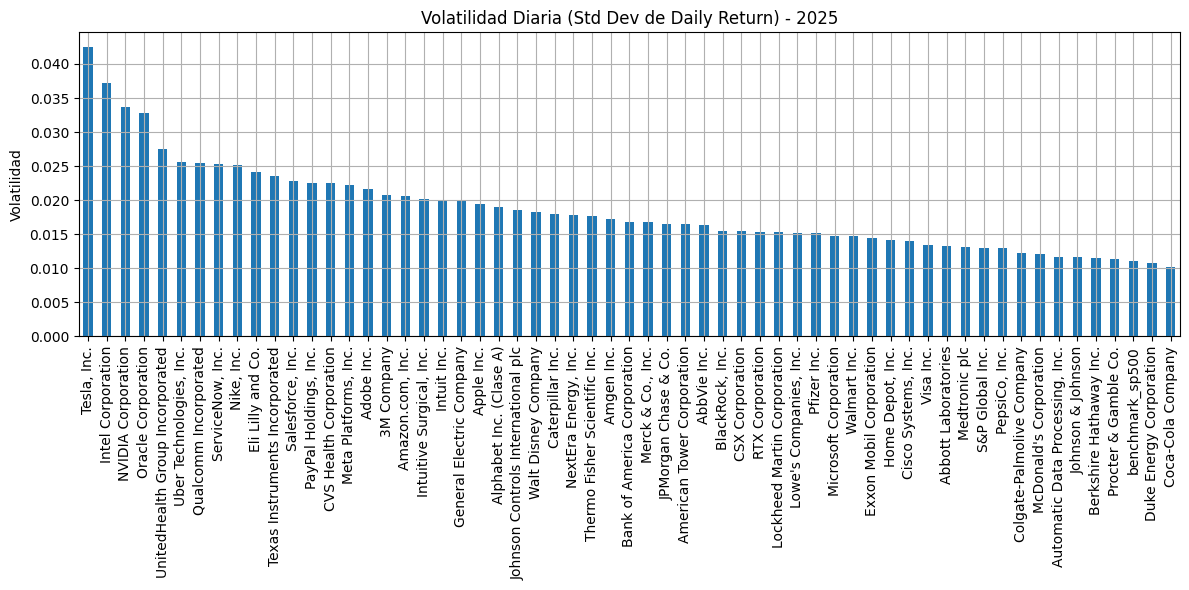

In [305]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in sp500_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
tickers_index = {
    "IWDA.AS": "MSCI World",
    "CSPX.AS": "S&P 500",
    "CS1.PA": "IBEX 35",
    "EUNK.DE": "Core MSCI Europe",
    "LYP6.DE": "Stoxx Europe 600",
    '^GSPC': "SP500 Index"
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
index_hist_df = extraction_historic(start_period, end_period, tickers_index)
index_analysed_df = analysis_stock_hist(index_hist_df, tickers_index, bechmark_sp500)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                 | 0/6 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed██████████████████████████████████████████████████████████████████▎                                                      | 4/6 [00:00<00:00, 32.42it/s]
[*********************100%***********************]  1 of 1 completed
Procesando tickers: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.34i

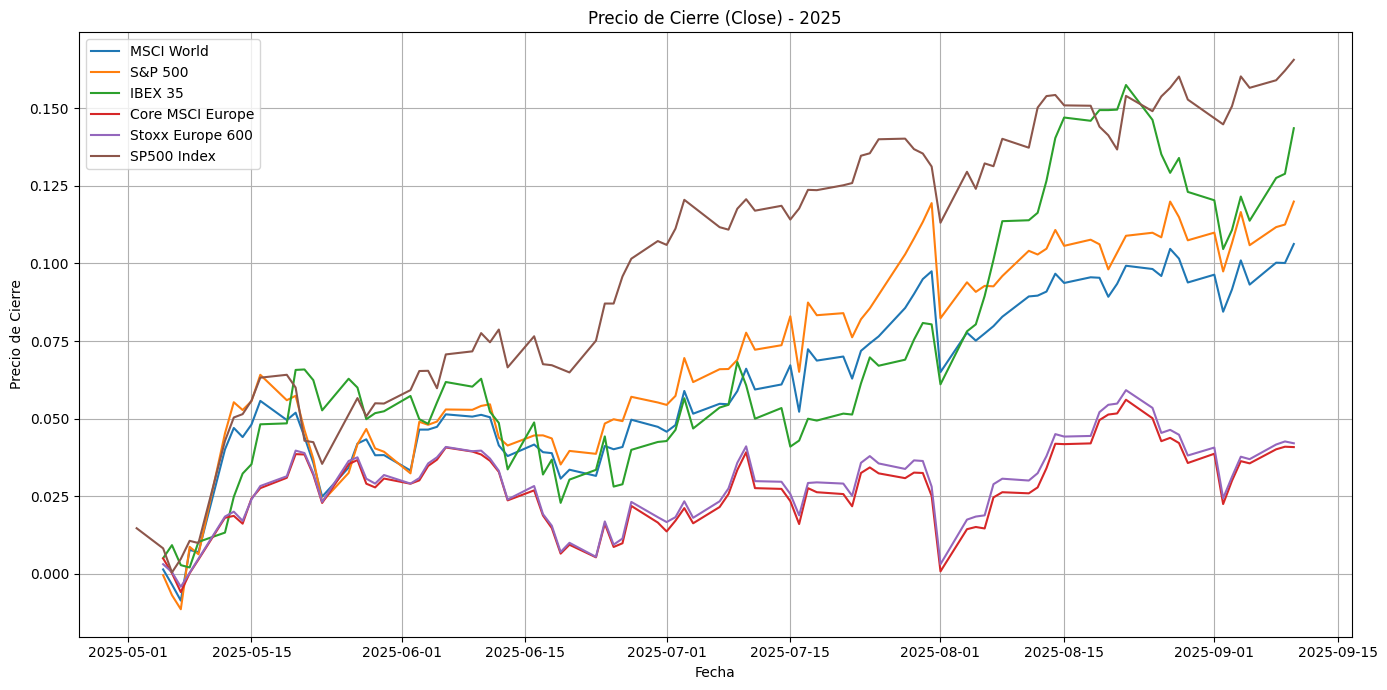

In [83]:
plt.figure(figsize=(14, 7))

for ticker, data in index_hist_df.items():
    plt.plot(data.index, data["Cumulative Return"], label=ticker)

plt.title("Precio de Cierre (Close) - 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

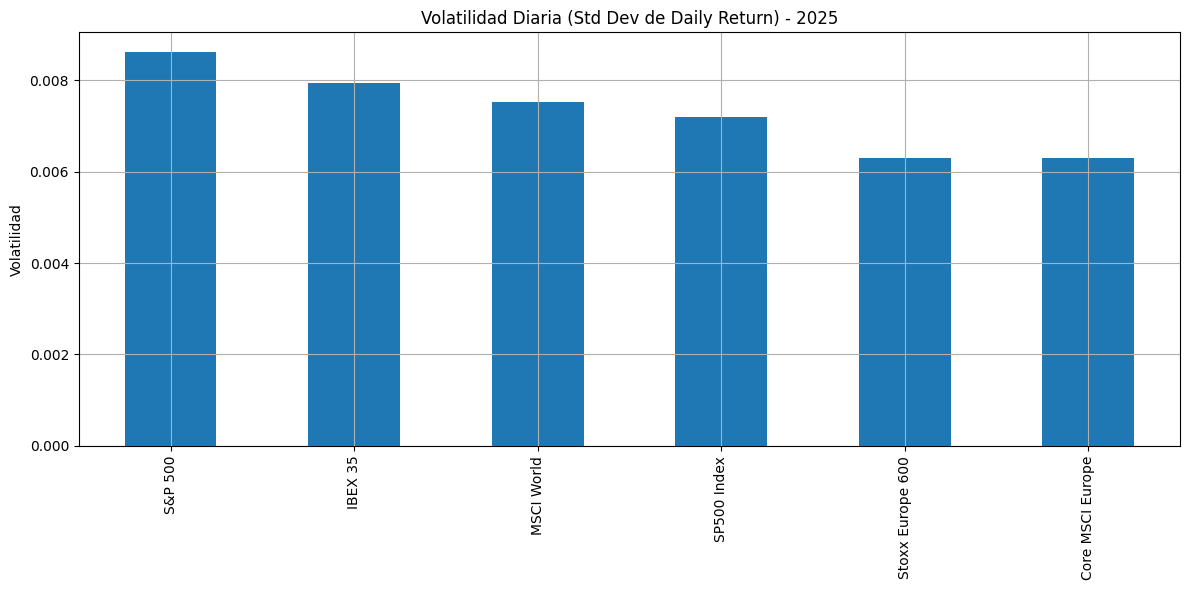

In [84]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in index_hist_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
index_analysed_df

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,Interpretacion Sharpe,volatilidad,alpha,beta
0,MSCI World,IWDA.AS,None,None,None,0.106260,0.094964,0.038906,105.775002,None,None,None,None,0.148326,Rentabilidad baja para el riesgo asumido,0.007513,-7.097513e-05,0.736022
1,S&P 500,CSPX.AS,None,None,None,0.119919,0.113361,0.043650,595.935974,None,None,None,None,0.145690,Rentabilidad baja para el riesgo asumido,0.008615,-6.435137e-06,0.799080
2,IBEX 35,CS1.PA,None,None,None,0.143541,0.080826,0.036821,382.000000,None,None,None,None,0.185939,Rentabilidad baja para el riesgo asumido,0.007930,5.793943e-04,0.549209
3,Core MSCI Europe,EUNK.DE,None,None,None,0.040858,0.032519,0.014771,87.379997,None,None,None,None,0.071602,Rentabilidad baja para el riesgo asumido,0.006289,-4.691752e-04,0.530112
4,Stoxx Europe 600,LYP6.DE,None,None,None,0.042085,0.036382,0.015536,264.950012,None,None,None,None,0.073505,Rentabilidad baja para el riesgo asumido,0.006299,-4.537836e-04,0.541577
5,SP500 Index,^GSPC,None,None,None,0.165574,0.136813,0.066528,6532.040039,None,None,None,None,0.240067,Rentabilidad baja para el riesgo asumido,0.007204,6.911789e-19,1.000000


In [86]:
start_period = datetime(2024,5,1)
end_period =  datetime(2025,9,11)

tickers_portafolio = {
    "GOOG": "Alphabet (Google)",
    "AMZN": "Amazon",
    #"ASTS": "AST SpaceMobile",
    "BRK-B": "Berkshire Hathaway B",
    "IWDA.AS": "MSCI World (iShares)",
    "CSPX.AS": "S&P 500 (iShares)",
    "HUBS": "HubSpot",
    "IAG.MC": "IAG (Iberia)",
    "CS1.PA": "CAC 40 / IBEX ETF",
    "ITX.MC": "Inditex",
    "MSFT": "Microsoft",
    "NVDA": "NVIDIA",
    "SNY": "Sanofi",
    "UNH": "UnitedHealth",
    "^GSPC": "benchmark_sp500",
    "^IBEX": "benchmark_ibex35",
}

bechmark_sp500 = call_yf_api_historic(start_period, end_period, '^GSPC')
portafolio_hist_df = extraction_historic(start_period, end_period, tickers_portafolio)
portafolio_analysed_df = analysis_stock_hist(portafolio_hist_df, tickers_portafolio, bechmark_sp500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed                                                                                                                                | 0/15 [00:00<?, ?it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 1/15 [00:00<00:02,  4.73it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 2/15 [00:00<00:02,  4.97it/s]
[*********************100%***********************]  1 of 1 completed                                                                                                                        | 3/15 [00:00<00:02,  5.11it/s]
[*********************100%***********************] 

In [87]:
portafolio_analysed_df

,Empresa,Ticker,Sector,Industria,Capitalización mercado,Retorno 1 mes,Retorno 2 meses,Retorno 3 meses,Precio actual,Precio objetivo analistas,Rentabilidad prevista,Valoración analistas,Interpretacion recomendacion,sharpe_ratio,Interpretacion Sharpe,volatilidad,alpha,beta
5,HubSpot,HUBS,Technology,Software - Application,2.618136e+10,-0.192892,-0.095299,-0.084971,489.179993,699.84000,43.1,1.37143,Compra fuerte (Strong Buy),-0.010193,Mala inversión (rinde peor que activo libre de...,0.026728,-1.292765e-03,1.346010
11,Sanofi,SNY,Healthcare,Drug Manufacturers - General,1.170727e+11,0.026126,0.073777,0.080740,47.160000,61.61111,30.6,1.70000,Compra (Buy),0.012843,Rentabilidad baja para el riesgo asumido,0.016307,2.174799e-05,0.273151
9,Microsoft,MSFT,Technology,Software - Infrastructure,3.723275e+12,0.281071,0.310152,0.214019,500.369995,615.38390,23.0,1.26316,Compra fuerte (Strong Buy),0.056603,Rentabilidad baja para el riesgo asumido,0.014788,2.126529e-05,0.980561
10,NVIDIA,NVDA,Technology,Semiconductors,4.315993e+12,1.136301,1.114376,0.710318,177.330002,207.89210,17.2,1.41538,Compra fuerte (Strong Buy),0.083176,Rentabilidad baja para el riesgo asumido,0.033679,9.840711e-04,2.125635
6,IAG (Iberia),IAG.MC,Industrials,Airlines,2.119485e+10,1.182245,1.117582,0.817115,4.421000,5.06667,14.6,1.66667,Compra (Buy),0.118069,Rentabilidad baja para el riesgo asumido,0.020853,2.232696e-03,0.421290
1,Amazon,AMZN,Consumer Cyclical,Internet Retail,2.453674e+12,0.286760,0.290559,0.184916,230.330002,263.18033,14.3,1.33333,Compra fuerte (Strong Buy),0.046339,Rentabilidad baja para el riesgo asumido,0.020554,-2.594021e-04,1.379118
8,Inditex,ITX.MC,Consumer Cyclical,Apparel Retail,1.453475e+11,0.093258,0.030931,0.069194,45.430000,50.41304,11.0,2.13043,Compra (Buy),0.024877,Rentabilidad baja para el riesgo asumido,0.014584,1.128764e-04,0.306639
2,Berkshire Hathaway B,BRK-B,Financial Services,Insurance - Diversified,1.072683e+12,0.229565,0.195645,0.223192,490.079987,521.00000,6.3,NaN,None,0.058433,Rentabilidad baja para el riesgo asumido,0.011546,2.141045e-04,0.550937
12,UnitedHealth,UNH,Healthcare,Healthcare Plans,3.212607e+11,-0.267053,-0.448208,-0.342001,346.779999,335.41666,-3.3,1.92308,Compra (Buy),-0.018790,Mala inversión (rinde peor que activo libre de...,0.027494,-7.674959e-04,0.240493
0,Alphabet (Google),GOOG,Communication Services,Internet Content & Information,2.910601e+12,0.456782,0.193438,0.068584,239.559998,227.61578,-5.0,1.54545,Compra (Buy),0.068333,Rentabilidad baja para el riesgo asumido,0.018768,3.690538e-04,1.065588


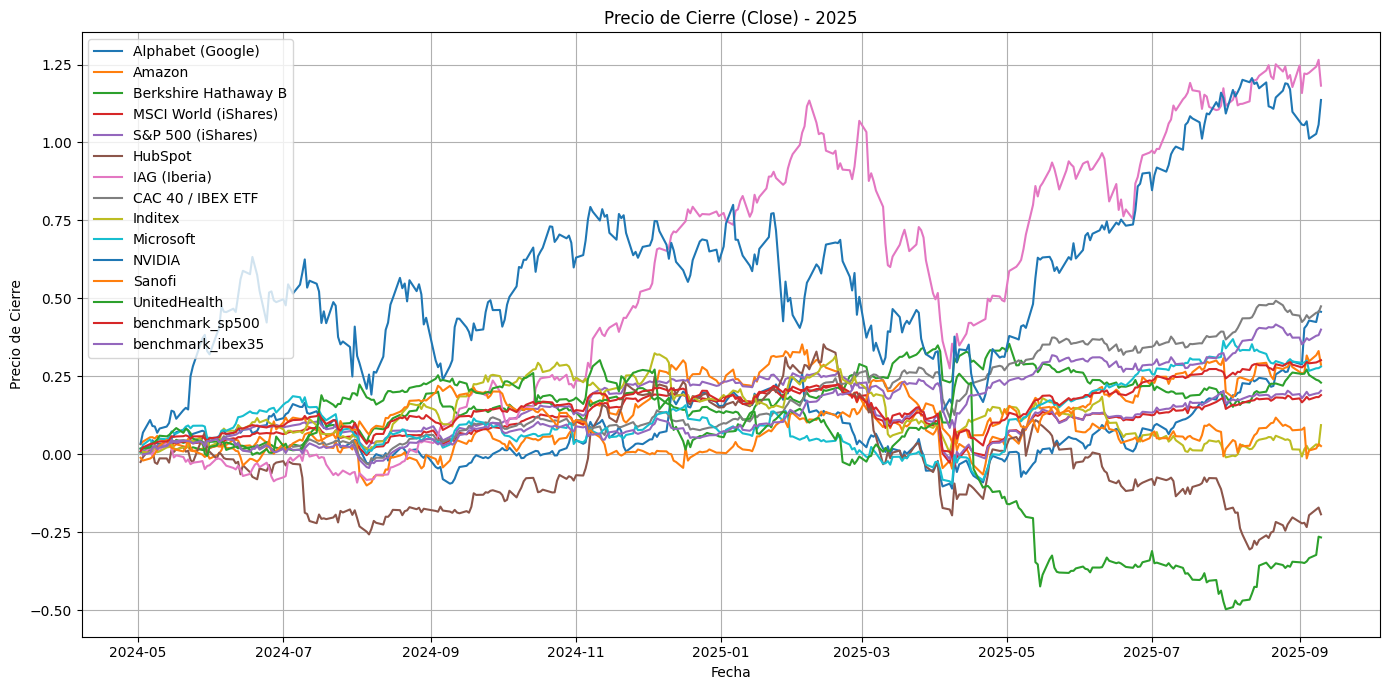

In [88]:
plt.figure(figsize=(14, 7))

for ticker, data in portafolio_hist_df.items():
    plt.plot(data.index, data["Cumulative Return"], label=ticker)

plt.title("Precio de Cierre (Close) - 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

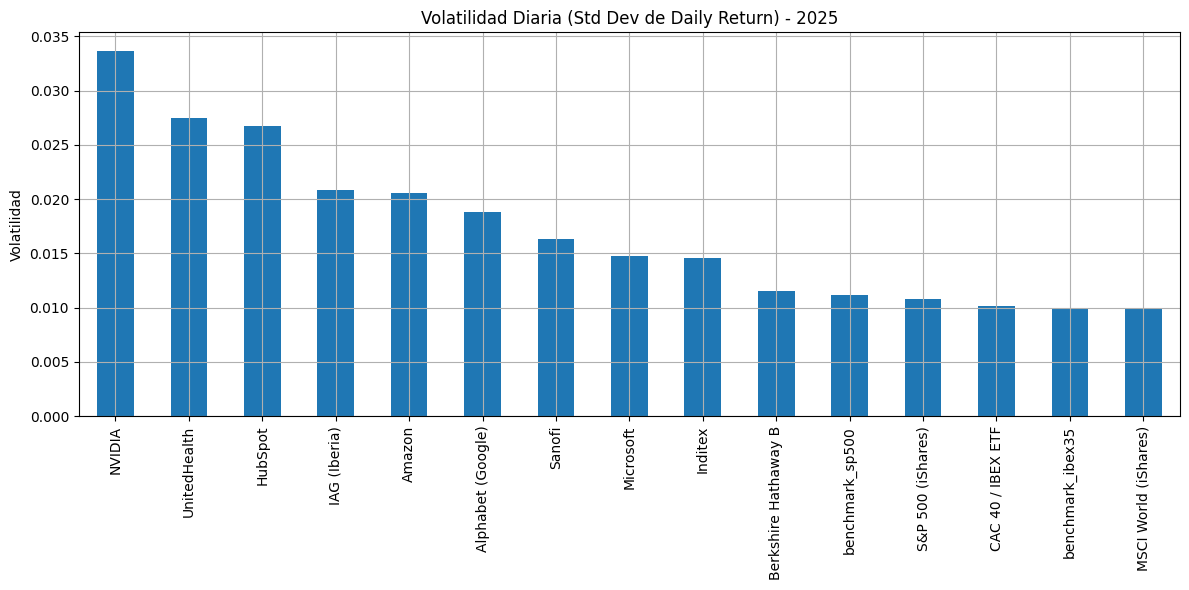

In [89]:
volatilities = {
    ticker: data["Daily Return"].std() for ticker, data in portafolio_hist_df.items()
}

# Convertir a DataFrame y graficar
vol_df = pd.DataFrame.from_dict(volatilities, orient='index', columns=["Volatilidad"])
vol_df.sort_values("Volatilidad", ascending=False).plot(kind='bar', figsize=(12, 6), legend=False)

plt.title("Volatilidad Diaria (Std Dev de Daily Return) - 2025")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [250]:
import statsmodels.api as sm

def compute_alpha_beta(stock_data, benchmark_data):
    """
    Calcula Alpha y Beta de un activo respecto a un benchmark.
    stock_data y benchmark_data deben ser Series con retornos diarios (%).
    """
    # Alinear índices de fechas
    data = pd.concat([stock_data, benchmark_data], axis=1).dropna()
    stock_returns = data.iloc[:, 0]
    benchmark_returns = data.iloc[:, 1]

    # Regresión lineal: stock = alpha + beta * benchmark
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(stock_returns, X).fit()
    alpha, beta = model.params

    return alpha, beta

In [ ]:
stock_data = portafolio_hist_df['S&P 500 (iShares)']["Daily Return"]
benchmark_data = portafolio_hist_df['benchmark_sp500']["Daily Return"]

In [280]:
compute_alpha_beta(portafolio_hist_df['Alphabet (Google)']["Daily Return"], portafolio_hist_df['benchmark_sp500']["Daily Return"])

(0.0003894773820678729, 1.0670446888851592)

In [37]:
stock_data = ibex35_df['Banco Santander']["Daily Return"]
benchmark_data = bechmark_ibex35["Daily Return"]

data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

stock_returns = data.iloc[:, 0]
benchmark_returns = data.iloc[:, 1]

# Regresión lineal: stock = alpha + beta * benchmark
X = sm.add_constant(benchmark_returns)
model = sm.OLS(stock_returns, X).fit()
alpha, beta = model.params

/tmp/ipykernel_6496/1285566722.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range


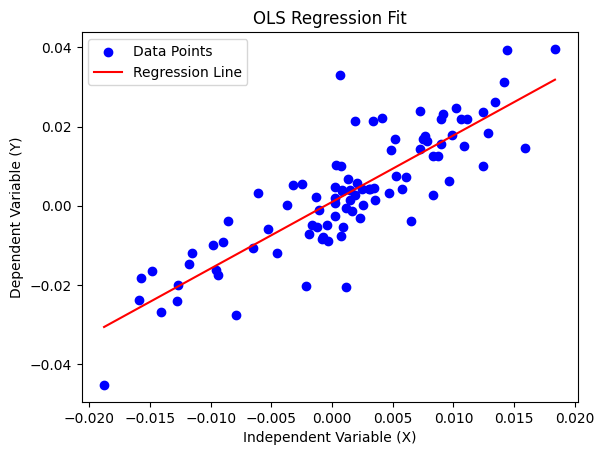

In [40]:
plt.scatter(benchmark_returns, stock_returns, color='blue', label='Data Points')

x_range = np.linspace(benchmark_returns.min(), benchmark_returns.max(), 100)
y_pred = model.params[0] + model.params[1] * x_range 

plt.plot(x_range, y_pred, color='red', label='Regression Line')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (Y)')
plt.title('OLS Regression Fit')
plt.legend()
plt.show()

In [58]:
stock_data = sp500_df['Alphabet Inc. (Clase A)']["Close"]
benchmark_data = bechmark_sp500["Close"]

data = pd.merge(
        stock_data.rename("stock"),
        benchmark_data.rename("benchmark"),
        left_index=True,
        right_index=True,
        how="left"
    ).dropna()

stock_returns = data.iloc[:, 0].pct_change(1).dropna()
benchmark_returns = data.iloc[:, 1].pct_change(1).dropna()

# Regresión lineal: stock = alpha + beta * benchmark
X = sm.add_constant(benchmark_returns)
model = sm.OLS(stock_returns, X).fit()
alpha, beta = model.params

/tmp/ipykernel_6496/1285566722.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + model.params[1] * x_range


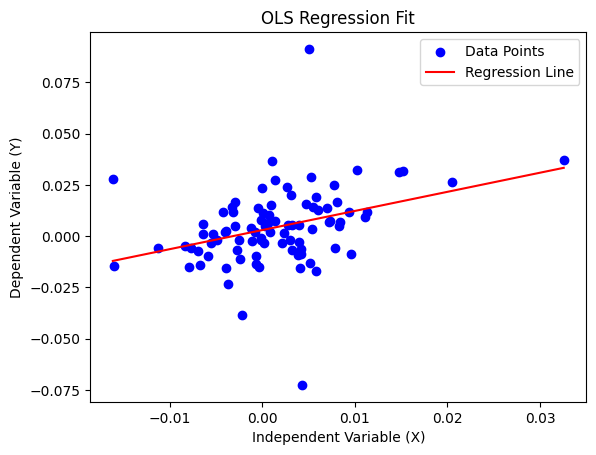

In [61]:
plt.scatter(benchmark_returns, stock_returns, color='blue', label='Data Points')

x_range = np.linspace(benchmark_returns.min(), benchmark_returns.max(), 100)
y_pred = model.params[0] + model.params[1] * x_range 

plt.plot(x_range, y_pred, color='red', label='Regression Line')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (Y)')
plt.title('OLS Regression Fit')
plt.legend()
plt.show()